![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [23]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [24]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

print(bikes.groupby('workingday').total.describe())

print("\nLa mayor cantidad de bicicletas alquiladas se alcanzó en un día laboral,  977 alquiladas en promedio.")
print("En esta variable 'workinday' se observa que hay más observaciones para días laborales (working days) que no laborales.")
print("Esto sugiere que hay más movimiento de alquileres en días laborales.  Sin embargo, los promedios de bicicletas alquiladas son similares,  188.50 para workingday==0 y 193.01 para días laborales (workingday==1)")


             count        mean         std  min   25%    50%    75%    max
workingday                                                                
0           3474.0  188.506621  173.724015  1.0  44.0  128.0  304.0  783.0
1           7412.0  193.011873  184.513659  1.0  41.0  151.0  277.0  977.0

La mayor cantidad de bicicletas alquiladas se alcanzó en un día laboral,  977 alquiladas en promedio.
En esta variable 'workinday' se observa que hay más observaciones para días laborales (working days) que no laborales.
Esto sugiere que hay más movimiento de alquileres en días laborales.  Sin embargo, los promedios de bicicletas alquiladas son similares,  188.50 para workingday==0 y 193.01 para días laborales (workingday==1)


In [25]:
# Celda 1.2
bikes.groupby('hour').total.mean()

print(bikes.groupby('hour').total.describe())

print("\nDurante las primeras horas del día entre las 8 y 9 parece existir una leve alza de alquileres al revisar el máximo de 596 y 839 bicicletas alquiladas.")
print("Pero en el rango de las 17 y 18 horas es evidente que se alquilan la mayor cantidad de bicicletas en promedio.")


print("Esto sugiere una posible correspondencia del aumento de alquileres con la hora de entrada y salida de los trabajadores.")



      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00   28.0
5     452.0   19.767699   12.784293   1.0    8.00   19.0   29.00   57.0
6     455.0   76.259341   54.745333   1.0   24.50   75.0  118.00  213.0
7     455.0  213.116484  159.207044   1.0   63.00  208.0  334.00  596.0
8     455.0  362.769231  231.723065   8.0  133.50  392.0  563.50  839.0
9     455.0  221.780220   92.099209  14.0  161.00  217.0  294.50  414.0
10    455.0  175.092308  101.807629  17.0  106.00  149.0  218.50  539.0
11    455.0  210.674725  127.444294  10.0  123.00  183.0  265.50

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

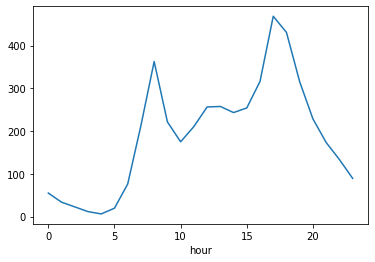

In [26]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()


Es notorio que los fines de semana o feriados (workingdays==0) el alquiler de bicicleta sigue una distribución normal que aumenta desde la mañana hasta el atardecer y desciende durante las horas nocturnas
Además el máximo de alquileres no sobrepasa en promedio las 400 bicicletas por hora.


<AxesSubplot:xlabel='hour'>

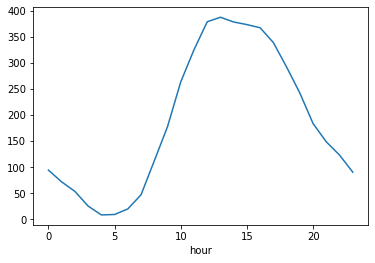

In [27]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 

print("\nEs notorio que los fines de semana o feriados (workingdays==0) el alquiler de bicicleta sigue una distribución normal que aumenta desde la mañana hasta el atardecer y desciende durante las horas nocturnas")
print("Además el máximo de alquileres no sobrepasa en promedio las 400 bicicletas por hora.")

bikes[bikes.workingday == 0].groupby('hour').total.mean().plot()


Se observa que en días laborales (workingday==1) la cantidad de bicicletas alquiladas son superiores en los rangos de la 8 a 9am y luego de las 17 a 18 horas.
Esta distribución bimodal sugiere una correspondencia con el viaje de los trabajadores durante la semana laboral.
Adicionalmente, es notorio que la cantidad promedio de bicicletas alquiladas, en comparación con los días feriados o no laborales (workingday==0), alcanza máximos superiores a las 400 bicicletas alquiladas.


<AxesSubplot:xlabel='hour'>

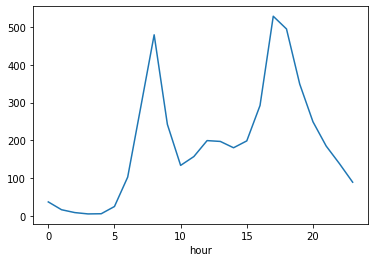

In [28]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
print('\nSe observa que en días laborales (workingday==1) la cantidad de bicicletas alquiladas son superiores en los rangos de la 8 a 9am y luego de las 17 a 18 horas.')
print('Esta distribución bimodal sugiere una correspondencia con el viaje de los trabajadores durante la semana laboral.')
print('Adicionalmente, es notorio que la cantidad promedio de bicicletas alquiladas, en comparación con los días feriados o no laborales (workingday==0), alcanza máximos superiores a las 400 bicicletas alquiladas.')
bikes[bikes.workingday == 1].groupby('hour').total.mean().plot()

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [29]:
# Celda 3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X = bikes[['hour', 'workingday']]
y = bikes.total

modelo = LinearRegression()
modelo.fit(X, y)

mse_linearReg = mean_squared_error(modelo.predict(X), y)

print("MSE:", mse_linearReg)

print("Coeficientes del modelo: ", modelo.coef_)

print('\nPor cada hora que transcurra se puede esperar que la cantidad de bicicletas alquiladas aumente un promedio de 10.49.')
print('Un aumento de la variable workingday significa un aumento promedio de 4.07 bicicletas alquiladas.')
print('\nLa limintación de este modelo es que un aumento de hour o working no significa que una cause a la otra, por el contrario podría existir una relación o multicolinealidad entre ellas.')
print('Adicionalmente, este modelo aunque sea muy interpretable tiene poca flexibilidad, un mayor sesgo y al utilizar todo el conjunto de datos podría estar sobreajustado (overfittig)')



MSE: 27541.255252498402
Coeficientes del modelo:  [10.49206282  4.07248627]

Por cada hora que transcurra se puede esperar que la cantidad de bicicletas alquiladas aumente un promedio de 10.49.
Un aumento de la variable workingday significa un aumento promedio de 4.07 bicicletas alquiladas.

La limintación de este modelo es que un aumento de hour o working no significa que una cause a la otra, por el contrario podría existir una relación o multicolinealidad entre ellas.
Adicionalmente, este modelo aunque sea muy interpretable tiene poca flexibilidad, un mayor sesgo y al utilizar todo el conjunto de datos podría estar sobreajustado (overfittig)


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [30]:
# Celda 4

# Definición de la función que calcula el mse que se usa para particionar
def mse(y):
    #print(y.mean())
    return ((y - y.mean())**2).mean()
    
# Definición de una función costo del split
def eval_mse_split(X_col, y, split):    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    dispersionPromedio_l = mse_l * (n_l / (n_l + n_r) )
    dispersionPromedio_r = mse_r * (n_r / (n_l + n_r) )
    
    split_mse =  dispersionPromedio_l + dispersionPromedio_r
    
    return split_mse


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def bestMSE_split(X, y, num_pct=10):
    
    features = range(X.shape[1])    
    
    best_split = [0, 0, 0]  # j, split, mse
    inicia = 1        
    
    # Para todas las varibles 
    for j in features:                
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        #print(splits)
        
        # Para cada partición se calcula su costo (mse) con el fin de identificar la de menor costo.
        for split in splits:
            mse_split = eval_mse_split(X.iloc[:, j], y, split)
            #print(split, mse_split)
               
            if inicia == 0:                         
                if mse_split < best_split[2]:
                    best_split = [j, split, mse_split]
            else: best_split = [j, split, mse_split]
            inicia = 0
                
        #print('mejor split del feature', j, ':' , best_split)    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0, esHoja=1)
        return tree
    
    # Calcular la mejor división
    j, split, mse = bestMSE_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse, esHoja=0)

    if max_depth is not None:
        if level >= max_depth:
            tree['esHoja']=1
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1,  max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1,  max_depth=max_depth, num_pct=num_pct)
    
    return tree
#
X = bikes[['hour', 'workingday']]
y = bikes.total

arbol = tree_grow(X, y, level=0, max_depth=3, num_pct=10)

print('\n*** A continuación se muestra el árbol con 8 nodos finales generados: \n')

arbol




*** A continuación se muestra el árbol con 8 nodos finales generados: 



{'y_pred': 1,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'mse': 23675.892974467803,
 'esHoja': 0,
 'sl': {'y_pred': 1,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'mse': 4569.219380357904,
  'esHoja': 0,
  'sl': {'y_pred': 1,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'mse': 1242.1585299291157,
   'esHoja': 0,
   'sl': {'y_pred': 1,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'mse': 754.3758482230128,
    'esHoja': 1},
   'sr': {'y_pred': 1,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'mse': 1509.6453517339176,
    'esHoja': 1}},
  'sr': {'y_pred': 1,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 455,
   'mse': 12425.746772115546,
   'esHoja': 0,
   'sl': {'y_pred': 1,
    'level': 3,
    'split': -1,
    'n_samples': 145,
    'mse': 0,
    'esHoja': 1},
   'sr': {'y_pred': 1,
    'level': 3,
    'split': -1,
    'n_samples': 310,
    'mse': 0,
    'esHoja': 1}}},
 'sr': {'y_pred': 1,
  'level': 1,
  'sp

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

Mejor desempeño y profundidad: (13143.121883295113, 10)
MSE: 11329.31152387664
Este modelo tiene mayor poder predictivo.  El MSE de 11329.31 es mucho menor al 27541.26 elaborado en el punto 3.


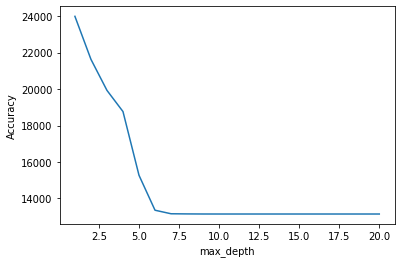

In [31]:
# Celda 5
%matplotlib inline
import matplotlib.pyplot as plt
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores
scores = []

X = bikes[['hour', 'workingday']]
y = bikes.total

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión
    modelo = DecisionTreeRegressor(max_depth=depth, random_state=1)
    scores.append(-cross_val_score(modelo, X, y, cv=10, scoring='neg_mean_squared_error').mean())   
    
plt.plot(max_depth_range, scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

max_depth_ = sorted(zip(scores, max_depth_range))[::-1][-1][1]

print("Mejor desempeño y profundidad:", sorted(zip(scores, max_depth_range))[::-1][-1])

# se crea el arbol de decision con el max_depth_
reg = DecisionTreeRegressor(max_depth=max_depth_, random_state=1)
reg.fit(X, y)

mse = mean_squared_error( y, reg.predict(X))
print("MSE:", mse )

print('Este modelo tiene mayor poder predictivo.  El MSE de {:.2f} es mucho menor al {:.2f} elaborado en el punto 3.'.format(mse, mse_linearReg))


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [32]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [33]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [34]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [35]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

lr =  LogisticRegression(random_state=0).fit(X_train, y_train)

prediccionesLR=lr.predict(X_test)

accuracyLR = metrics.accuracy_score(y_test, prediccionesLR)
f1LR = metrics.f1_score(y_test, prediccionesLR)

max_depth_range = range(1, 21)
scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clasif = DecisionTreeClassifier(max_depth=depth, random_state=1)
    scores.append(cross_val_score(clasif, X_train, y_train, cv=10, scoring='accuracy').mean())
    
max_depth_ = sorted(zip(scores, max_depth_range))[::-1][0][1]

print("Para el Arbol de Decisión el mejor desempeño se encontró con un profundidad == {0} :".format(max_depth_))

# se crea el arbol de decision con el max_depth_ calibrado
dt = DecisionTreeClassifier(max_depth=max_depth_, random_state=1).fit(X_train, y_train)

prediccionesDT=dt.predict(X_test)
accuracyDT = metrics.accuracy_score(y_test, prediccionesDT)
f1DT = metrics.f1_score(y_test, prediccionesDT)

print('\n\t\tRegresión logística', '\tArbol de Decisión')
print('Accuracy', '\t', '{:.4f}'.format(accuracyLR), '\t\t', '{:.4f}'.format(accuracyDT))
print('F1-Score', '\t', '{:.4f}'.format(f1LR), '\t\t', '{:.4f}'.format(f1DT))

Para el Arbol de Decisión el mejor desempeño se encontró con un profundidad == 2 :

		Regresión logística 	Arbol de Decisión
Accuracy 	 0.6127 		 0.6453
F1-Score 	 0.6093 		 0.6449


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [36]:
# Celda 7
from sklearn.ensemble import BaggingClassifier

n_estimators  = 100
max_samples = 300
# arbol con max_depth = None
dt_None = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_None = dt_None.predict(X_test)
f1DT_None, accuracyDT_None = metrics.f1_score(y_pred_None, y_test), metrics.accuracy_score(y_pred_None, y_test)

# arbol max_depth = 2
dt_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_2 = dt_2.predict(X_test)
f1DT_2, accuracyDT_2 = metrics.f1_score(y_pred_2, y_test), metrics.accuracy_score(y_pred_2, y_test)

# regresion logistica
regLog = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_regLog = regLog.predict(X_test)
f1_RegLog, accuracy_RegLog = metrics.f1_score(y_pred_regLog, y_test), metrics.accuracy_score(y_pred_regLog, y_test)

print('\n\t\tRegresión', '\tArbolDecisión', '\t', '\tArbolDecisión')
print('\t\tlogística', '\t(maxDepth=None)', '\t', '(maxDepth=2)')
print('Accuracy', '\t', '{:.4f}'.format(accuracy_RegLog), '\t', '{:.4f}'.format(accuracyDT_None), '\t\t', '{:.4f}'.format(accuracyDT_2))
print('F1-Score', '\t', '{:.4f}'.format(f1_RegLog), '\t', '{:.4f}'.format(f1DT_None), '\t\t', '{:.4f}'.format(f1DT_2))


		Regresión 	ArbolDecisión 	 	ArbolDecisión
		logística 	(maxDepth=None) 	 (maxDepth=2)
Accuracy 	 0.6187 	 0.6613 		 0.6453
F1-Score 	 0.6135 	 0.6568 		 0.6316


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [37]:
# Celda 8
from sklearn.ensemble import BaggingClassifier

def prediccionPonderada(X_test, clf):
    # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
    errors = np.zeros(clf.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
        
    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)    
    
    return y_pred

n_estimators  = 100
max_samples = 300

# arbol con max_depth = None
dt_None = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_None = prediccionPonderada(X_test, dt_None)
pf1DT_None, paccuracyDT_None = metrics.f1_score(y_pred_None, y_test), metrics.accuracy_score(y_pred_None, y_test)

# arbol max_depth = 2
dt_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_2 = prediccionPonderada(X_test, dt_2)
pf1DT_2, paccuracyDT_2 = metrics.f1_score(y_pred_2, y_test), metrics.accuracy_score(y_pred_2, y_test)

# regresion logistica
regLog = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=n_estimators, bootstrap=True,
                            random_state=42, n_jobs=-1, oob_score=True, max_samples=max_samples).fit(X_train, y_train)
y_pred_regLog = prediccionPonderada(X_test, regLog)
pf1_RegLog, paccuracy_RegLog = metrics.f1_score(y_pred_regLog, y_test), metrics.accuracy_score(y_pred_regLog, y_test)

print('\n\t\tRegresión', '\tArbolDecisión', '\t', '\tArbolDecisión')
print('\t\tlogística', '\t(maxDepth=None)', '\t', '(maxDepth=2)')
print('Accuracy', '\t', '{:.4f}'.format(paccuracy_RegLog), '\t', '{:.4f}'.format(paccuracyDT_None), '\t\t', '{:.4f}'.format(paccuracyDT_2))
print('F1-Score', '\t', '{:.4f}'.format(pf1_RegLog), '\t', '{:.4f}'.format(pf1DT_None), '\t\t', '{:.4f}'.format(pf1DT_2))



		Regresión 	ArbolDecisión 	 	ArbolDecisión
		logística 	(maxDepth=None) 	 (maxDepth=2)
Accuracy 	 0.6193 	 0.6633 		 0.6467
F1-Score 	 0.6150 	 0.6631 		 0.6325


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [38]:
# Celda 9
print('\n\t\t\tRegresión', '\tArbolDecisión', '\t', '\tArbolDecisión')
print('\t\t\tlogística', '\t(maxDepth=None)', '\t', '(maxDepth=2)')
print('Accuracy (mayoritaria)', '\t', '{:.4f}'.format(accuracy_RegLog), '\t', '{:.4f}'.format(accuracyDT_None), '\t\t', '{:.4f}'.format(accuracyDT_2))
print('Accuracy (ponderada)', '\t', '{:.4f}'.format(paccuracy_RegLog), '\t', '{:.4f}'.format(paccuracyDT_None), '\t\t', '{:.4f}'.format(paccuracyDT_2))
print('F1-Score (mayoritaria', '\t', '{:.4f}'.format(f1_RegLog), '\t', '{:.4f}'.format(f1DT_None), '\t\t', '{:.4f}'.format(f1DT_2))
print('F1-Score (ponderada)', '\t', '{:.4f}'.format(pf1_RegLog), '\t', '{:.4f}'.format(pf1DT_None), '\t\t', '{:.4f}'.format(pf1DT_2))

print('\n')
print('El clasificador con menor poder predictivo, sin importar el mecanismo de votación utilizado, es la Regresión Logística.')
print('Es evidente que el ensamblaje con votación ponderada favorece en cualquiera de los 3 escenarios.')
print('Por el tiempo de ejecución se comprueba que se requiere mayor poder de cómputo para implementar la votación ponderada de los clasificadores.')
print('Tanto la métrica de accuracy como F1-Score es mejor si se utiliza votación ponderada en todos los clasificadores.')
print('El mejor rendimiento, acurracy = {:.4f}, se obtiene con la votación ponderada para el arbol de decisión con maxDepth=None.'.format(paccuracyDT_None))
print('Por lo tanto, el arbol de decisión con maxDepth=None y un ensamblaje con votación ponderada sería el clasificador con mayor poder predictivo.')

print('')


			Regresión 	ArbolDecisión 	 	ArbolDecisión
			logística 	(maxDepth=None) 	 (maxDepth=2)
Accuracy (mayoritaria) 	 0.6187 	 0.6613 		 0.6453
Accuracy (ponderada) 	 0.6193 	 0.6633 		 0.6467
F1-Score (mayoritaria 	 0.6135 	 0.6568 		 0.6316
F1-Score (ponderada) 	 0.6150 	 0.6631 		 0.6325


El clasificador con menor poder predictivo, sin importar el mecanismo de votación utilizado, es la Regresión Logística.
Es evidente que el ensamblaje con votación ponderada favorece en cualquiera de los 3 escenarios.
Por el tiempo de ejecución se comprueba que se requiere mayor poder de cómputo para implementar la votación ponderada de los clasificadores.
Tanto la métrica de accuracy como F1-Score es mejor si se utiliza votación ponderada en todos los clasificadores.
El mejor rendimiento, acurracy = 0.6633, se obtiene con la votación ponderada para el arbol de decisión con maxDepth=None.
Por lo tanto, el arbol de decisión con maxDepth=None y un ensamblaje con votación ponderada sería el clasificador